In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2 as cv 
from kaggle_datasets import KaggleDatasets

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2022-11-25 20:22:35.544268: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-25 20:22:35.544413: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-11-25 20:22:41.641166: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-25 20:22:41.644297: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-25 20:22:41.644336: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 20:22:41.644363: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e085986736f2): /proc/driver/nvidia/version does not exist
2022-11-25 20:22:41.647930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [5]:
IMAGE_SIZE = [192, 192] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 5
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
AUTO = tf.data.experimental.AUTOTUNE

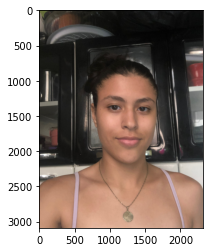

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

with open('../input/selfies-id-images-dataset/11_sets_Hispanics/0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana/Selfie_9.jpg', "rb") as local_file: # <= change here
    img = local_file.read()
img = tf.io.decode_jpeg(img, channels=3)
imgplot = plt.imshow(img)

In [7]:
images = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))
images = pd.DataFrame(images,columns=['filenames'])

In [8]:
images['given_names'] = images.filenames.apply(lambda x: x[x.find('name')+5:x.find('/',x.find('name')+5)])

In [9]:
images["image_type"] = images.filenames.apply(lambda x: x[x.find('/',x.find('name')+5)+1:x.find('_',x.find('name')+5)])

In [10]:
images = images[2:].reset_index(drop=True)

In [11]:
images

,filenames,given_names,image_type
0,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
1,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,ID
2,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
3,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
4,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,ID
...,...,...,...
428,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
429,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
430,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
431,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie


In [12]:
def build_facematch_dataset(images):
    X1_dataset = []
    X2_dataset = []
    y1_dataset = []
    y2_dataset = []
    for i in range(len(images)-2):
        X1_dataset.append(images.filenames[i])
        X2_dataset.append(images.filenames[i+1])
        if images.given_names[i] == images.given_names[i+1]:
            y1_dataset.append(1)
        else:
            y1_dataset.append(0)
        if images.image_type[i+1] == 'ID':
            y2_dataset.append(0)
        else:
            y2_dataset.append(1)
    for i in range(len(images)):
        first_sample = np.random.randint(0,len(images))
        second_sample = np.random.randint(0,len(images))
        X1_dataset.append(images.filenames[first_sample])
        X2_dataset.append(images.filenames[second_sample])
        if images.given_names[first_sample] == images.given_names[second_sample]:
            y1_dataset.append(1)
        else:
            y1_dataset.append(0)
        if images.image_type[second_sample] == 'ID':
            y2_dataset.append(0)
        else:
            y2_dataset.append(1)
        
    return tf.data.Dataset.from_tensor_slices(({"input_1":X1_dataset,"input_2":X2_dataset},
                    {"facematch":y1_dataset,"liveness":y2_dataset}))

In [13]:
dataset = build_facematch_dataset(images)

In [14]:
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [15]:
def get_face_boxes(image):
    height, width = image.shape[0], image.shape[1]
    global face_cascade
    face = face_cascade.detectMultiScale(image.numpy(), 1.3, 5)
    for (x,y,w,h) in face:
        return x/width, y/height, (x+w)/width, (y+h)/height

In [16]:
def process_path(img):
    with open(img, "rb") as local_file: # <= change here
        image = local_file.read()
    image = tf.io.decode_jpeg(image, channels=1)
    
    try:
        x1, y1, x2, y2 = get_face_boxes(image)
        image = tf.image.crop_and_resize(tf.expand_dims(image, axis=0),
                                          tf.constant([[y1, x1, y2, x2]], dtype=tf.float32),
                                          tf.constant([0]), [192, 192, 1])
        image = tf.squeeze(image, axis=0)
    except:
        image = tf.image.resize(image, [192, 192, 1])
    
    image = image/255
    return image

In [17]:
def parse_func(img):
    return tf.py_function(process_path,[img],tf.float32)

In [18]:
dataset = dataset.map(lambda images, labels: 
                      ({"input_1":parse_func(images["input_1"]),
                        "input_2":parse_func(images["input_2"])},
                       labels))

In [19]:
@tf.function
def rot90_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=1)
    img2 = tf.image.rot90(images["input_2"],k=1)
    return {"input_1":img1,"input_2":img2},labels

In [20]:
@tf.function
def rot180_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=2)
    img2 = tf.image.rot90(images["input_2"],k=2)
    return {"input_1":img1,"input_2":img2},labels

In [21]:
@tf.function
def rot270_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=3)
    img2 = tf.image.rot90(images["input_2"],k=3)
    return {"input_1":img1,"input_2":img2},labels

In [22]:
@tf.function
def left_right_augment(images, labels):
    img1 = tf.image.flip_left_right(images["input_1"])
    img2 = tf.image.flip_left_right(images["input_2"])
    return {"input_1":img1,"input_2":img2},labels

In [23]:
@tf.function
def up_down_augment(images, labels):
    img1 = tf.image.flip_left_right(images["input_1"])
    img2 = tf.image.flip_left_right(images["input_2"])
    return {"input_1":img1,"input_2":img2},labels

In [24]:
rot90_dataset = dataset.map(rot90_augment)
rot180_dataset = dataset.map(rot180_augment)
rot270_dataset = dataset.map(rot270_augment)
left_right_dataset = dataset.map(left_right_augment)
up_down_dataset = dataset.map(up_down_augment)

In [25]:
dataset = dataset.concatenate(rot90_dataset)
dataset = dataset.concatenate(rot180_dataset)
dataset = dataset.concatenate(rot270_dataset)
dataset = dataset.concatenate(left_right_dataset)
dataset = dataset.concatenate(up_down_dataset)

In [26]:
dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=5184>

In [27]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [28]:
train, val, test = get_dataset_partitions_tf(dataset,dataset.__len__().numpy())

In [29]:
STEPS_PER_EPOCH = train.__len__()//BATCH_SIZE

In [30]:
train = train.shuffle(100).batch(BATCH_SIZE).prefetch(AUTO)
val = val.shuffle(100).batch(BATCH_SIZE).prefetch(AUTO)
test = test.shuffle(100).batch(BATCH_SIZE).prefetch(AUTO)

In [31]:
from tensorflow import keras

In [32]:
def input_layers(image_size):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[*image_size, 1]),
        keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(3),
        keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(3),
        keras.layers.Flatten()
    ])
    
    return model

In [33]:
def build_model():
    base_model_A = input_layers(IMAGE_SIZE)
    base_model_B = input_layers(IMAGE_SIZE)

    concat = keras.layers.Concatenate()([base_model_A.output,base_model_B.output])
    z = keras.layers.Dense(20,activation='relu')(concat)
    bn = keras.layers.BatchNormalization()(z)
    z = keras.layers.Dense(20,activation='relu')(bn)
    output_A = keras.layers.Dense(1,activation='sigmoid',name='facematch')(z)
    output_B = keras.layers.Dense(1,activation='sigmoid',name='liveness')(z)

    model = keras.Model(inputs=[base_model_A.input,base_model_B.input],outputs=[output_A,output_B])
    
    return model

In [34]:
with strategy.scope():
    model = build_model()
    
    model.layers[0]._name = 'input_1'
    model.layers[1]._name = 'input_2'
    
    optimizer = keras.optimizers.Nadam()
    model.compile(loss={'facematch':"binary_crossentropy",'liveness': "binary_crossentropy"},
              optimizer=optimizer,metrics={'facematch': 'binary_accuracy', 'liveness': 'binary_accuracy'})

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 192, 192, 32) 320         input_2[0][0]                    
______________________________________________________________________________________________

In [36]:
train.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=33>

In [37]:
history = model.fit(train,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_data=(val))

Epoch 1/5


TypeError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/tpu_strategy.py:540 run
        return self.extended.tpu_run(fn, args, kwargs, options)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/tpu_strategy.py:1296 tpu_run
        return func(args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/tpu_strategy.py:1345 tpu_function
        maximum_shape = tensor_shape.TensorShape([None] * rank)

    TypeError: can't multiply sequence by non-int of type 'NoneType'


In [ ]:
model.evaluate(test)